In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram
from neuropy.io.usvio import detect_tone

from tracefc.io.session_directory import get_session_dir

In [2]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
animal, sess_name = 'Jyn', 'training'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/Jyn_training_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 17071.19 seconds 
duration: 4.74 hours 



# deeplabcut

In [5]:
import neuropy.io.dlcio as dlcio
dlc_path = '/data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training'
arena_side_pix = 60  # Keep this
arena_side_cm = 25.4  # Update this after measuring!!!
pix2cm = arena_side_cm / arena_side_pix

# Read in DLC data
sess.dlc = dlcio.DLC(dlc_path, pix2cm=pix2cm)

# Smooth position, get timestamps, and get speed
sess.dlc.get_timestamps('ms_webcam', include_str="2_training")
sess.dlc.smooth_pos(bodyparts=["crown_middle", "back_middle"])
sess.dlc.timestamps["Timestamps"] = sess.dlc.timestamps["Timestamps"].dt.tz_localize("America/Detroit")
sess.dlc.get_all_speed()

Using tracking file #1: /data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/2_training/training/Jyn/gobears/2022_06_17/12_00_02/My_WebCam/Jyn_training_combined_movieDLC_resnet50_TraceFC_shockboxFeb28shuffle1_500000.h5


,back_middle,crown_middle,left_ear,neck_base,nose,right_ear,tail_base,tail_end,tail_middle
0,NaN,NaN,0.769831,1.935070,1.447852,2.398943,1630.949087,1377.072127,1340.004069
1,NaN,NaN,2.103007,0.933486,2.071056,4.012287,9.392645,4.245449,2072.053602
2,NaN,NaN,2.956544,3.245430,0.682751,5.340966,6.610737,3.439799,6.799220
3,NaN,NaN,3.009256,5.869671,1.125576,3.365958,1913.425353,2.651677,2.805702
4,NaN,NaN,2.266452,3.144328,0.641712,5.352335,1.119085,1.825762,0.211167
...,...,...,...,...,...,...,...,...,...
50092,NaN,NaN,1.843074,1.865239,1.767862,3.396596,5.117078,1.795202,2.705018
50093,NaN,NaN,3.226239,3.227691,2.081879,2.493561,4.535563,0.941303,5.806985
50094,NaN,NaN,2.940200,3.249997,0.960036,3.365971,3.267952,1.728327,5.692416
50095,NaN,NaN,2.209908,3.601523,1.963645,4.047442,2.463565,2.122795,2.021413


In [6]:
# Load in openephys times to sync
import neuropy.io.openephysio as oeio
sync_df = oeio.create_sync_df(sess.basepath)
sync_df["Total seconds from start"] = (sync_df["Datetime"] - sync_df["Datetime"][0]).dt.total_seconds()

# sync DLC times to your eeg file
sess.dlc.timestamps["Total seconds from OE start"] = (sess.dlc.timestamps["Timestamps"] - sync_df["Datetime"][0]).dt.total_seconds()
sess.dlc.timestamps["eeg_time"] = np.interp(sess.dlc.timestamps["Total seconds from OE start"], sync_df["Total seconds from start"], 
                                            sync_df["eeg_time"])
sess.dlc.timestamps

start time = 2022-06-17 11:49:35.167771-04:00
start time = 2022-06-17 11:59:21.708710-04:00
start time = 2022-06-17 12:36:31.859416-04:00
start time = 2022-06-17 15:27:42.768667-04:00
start time = 2022-06-17 12:36:31.859416-04:00
start time = 2022-06-17 13:00:21.503381-04:00
start time = 2022-06-17 13:41:54.130737-04:00
start time = 2022-06-17 13:54:57.288518-04:00
start time = 2022-06-17 14:01:14.359765-04:00
start time = 2022-06-17 14:04:58.639594-04:00
start time = 2022-06-17 14:26:31.373293-04:00
start time = 2022-06-17 14:35:21.609805-04:00
start time = 2022-06-17 14:35:21.609805-04:00
start time = 2022-06-17 14:35:21.609805-04:00
start time = 2022-06-17 15:19:01.281248-04:00


,Frame Number,Time Stamp (ms),Buffer Index,Timestamps,Total seconds from OE start,eeg_time
0,0,-15,0,2022-06-17 12:00:02.842000-04:00,627.674229,472.681275
1,1,33,0,2022-06-17 12:00:02.890000-04:00,627.722229,472.729275
2,2,64,0,2022-06-17 12:00:02.921000-04:00,627.753229,472.760275
3,3,113,0,2022-06-17 12:00:02.970000-04:00,627.802229,472.809275
4,4,154,0,2022-06-17 12:00:03.011000-04:00,627.843229,472.850275
...,...,...,...,...,...,...
50092,50092,2094768,0,2022-06-17 12:34:57.625000-04:00,2722.457229,2567.463529
50093,50093,2094808,0,2022-06-17 12:34:57.665000-04:00,2722.497229,2567.503529
50094,50094,2094856,0,2022-06-17 12:34:57.713000-04:00,2722.545229,2567.551529
50095,50095,2094895,0,2022-06-17 12:34:57.752000-04:00,2722.584229,2567.590529


In [7]:
# Last calculate freezing times and plot again to check
frz_thresh = 0.25 # cm/sec  Adjust this to something that looks reasonable!
duration_thresh = 1 # sec, must be below the threshold above for at least that long to be considered freezing
bodypart_use = "crown_middle"
frz_bool = sess.dlc.speed[bodypart_use] < frz_thresh
frz_epochs = Epoch.from_boolean_array(frz_bool, t=sess.dlc.timestamps["eeg_time"])
frz_df = frz_epochs.to_dataframe()
frz_df = frz_df[frz_epochs.durations > duration_thresh]
frz_epochs = Epoch(frz_df)
frz_epochs

235 epochs
Snippet: 
         start        stop  duration label
0  680.056201  681.063201  1.007000  high
1  747.671177  748.728177  1.057000  high
2  779.214166  781.095165  1.880999  high
3  781.127165  782.263165  1.136000  high
4  796.727160  798.951159  2.223999  high

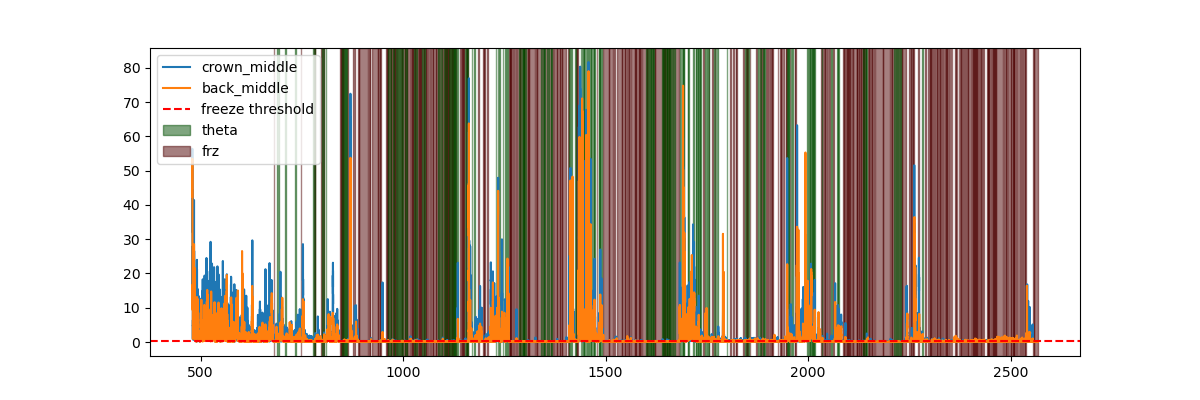

In [8]:
%matplotlib widget
# Plot to check! Looks ok, though there might be some mismatches between theta and movement.

_, ax = plt.subplots(figsize=(12, 4))
hc, = ax.plot(sess.dlc.timestamps["eeg_time"], sess.dlc.speed["crown_middle"])
hb, = ax.plot(sess.dlc.timestamps["eeg_time"], sess.dlc.speed["back_middle"])
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5])

# Now plot theta epochs over it to triple check!
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
theta_epochs = theta_epochs.time_slice(t_start = sess.dlc.timestamps["eeg_time"].min(), t_stop=sess.dlc.timestamps["eeg_time"].max())

for start, stop in zip(theta_epochs.starts, theta_epochs.stops):
    htheta = ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5])

ax.legend((hc, hb, hthresh, htheta, hf), ("crown_middle", "back_middle", "freeze threshold", "theta", "frz"))

,channel_states,timestamps,datetimes,event_name
913,2,2745124,2022-06-17 11:51:06.504133332,
1062,-2,3042701,2022-06-17 11:51:16.423366667,
1816,2,4564839,2022-06-17 11:52:07.161300000,
1964,-2,4863089,2022-06-17 11:52:17.102966667,
2824,2,6598149,2022-06-17 11:53:14.938300000,


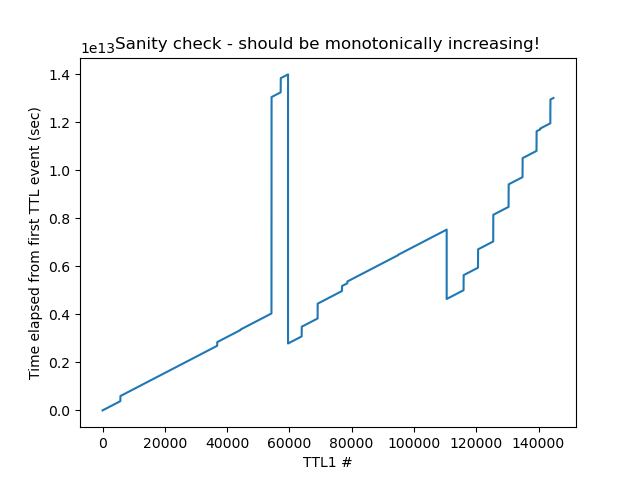

In [9]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

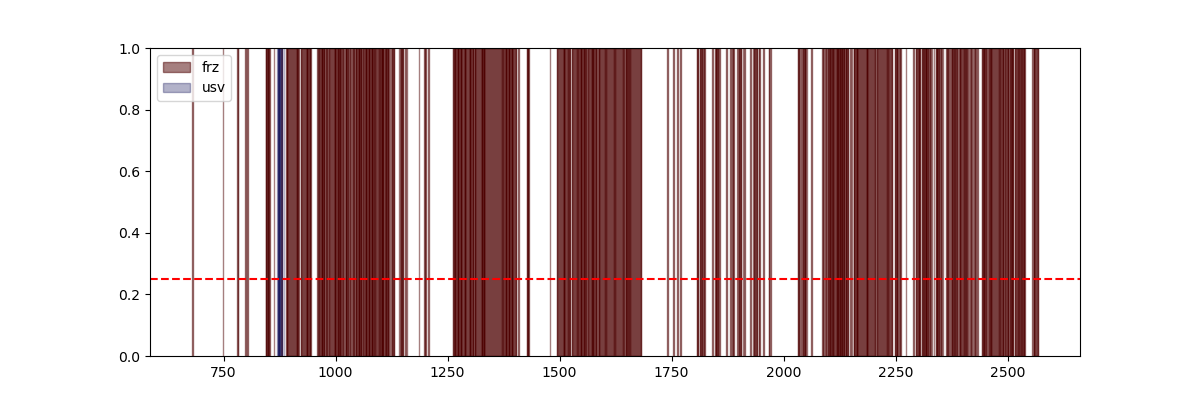

In [10]:
#Freezing and USV
from copy import deepcopy

manually_adjust_dlc_times = -0.528 
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')
    if duration > 3:  # Check if the frz epoch duration is greater than 5 seconds
        hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')

# theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
# theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
# theta_epochs = theta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
usv_epochs = Epoch(epochs=None, file=usv_epochs_file)
usv_epochs


# delta_epochs_file = sess.filePrefix.with_suffix(".delta_epochs.npy")
# delta_epochs = Epoch(epochs=None, file=delta_epochs_file)
# delta_epochs = delta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())


    
for start, stop in zip(usv_epochs.starts, usv_epochs.stops):
    duration = stop-start

    husv = ax.axvspan(start, stop, color=[0, 0, 0.3, 0.3], label='usv')
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
ax.legend(by_label.values(), by_label.keys())

In [11]:
usv_epochs

16 epochs
Snippet: 
         start        stop  Begin_Time   Freq_Min  Duration  Freq_Range  Score  \
0  870.126212  870.171338  505.926529  47.944444  0.045134   27.777778    1.0   
1  871.160586  871.233890  506.961084  45.345779  0.073317   25.343152    1.0   
2  871.556279  871.597182  507.356846  50.209416  0.040911    5.905844    1.0   
3  871.961179  872.056770  507.761818  46.842283  0.095608    5.095238    1.0   
4  872.405570  872.475605  508.206287  45.924784  0.070048    5.326840    1.0   

   Accept label  
0       1        
1       1        
2       1        
3       1        
4       1        

## Save notebook to animal working directory

In [12]:
from neuropy.utils.manipulate_files import save_notebook
try:
    save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")
except PermissionError:
    print('Got a weird PermissionError. Check to make sure file saved successfully')

/data/GitHub/TraceFC/Notebooks/Animal_files/Training notebooks/Sync_USV_and_Ephys(Jyn).ipynb saved to /data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/Jyn_training_Sync_USV_and_Ephys(Jyn).ipynb


### Load in disconnect and motion artifacts

In [13]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=31), thresh=11, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

Existing artifact epochs file loaded
Total artifact time = 108.6 seconds


/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,start,stop,label,duration
0,868.3664,870.7752,,2.4088
1,1160.5312,1162.5560,,2.0248
2,1432.4056,1435.9024,,3.4968
3,1711.3776,1713.6968,,2.3192
4,1971.0752,1973.5232,,2.4480
5,1999.2224,2001.6896,,2.4672
6,2261.2112,2263.2896,,2.0784
7,2633.3672,2634.5616,,1.1944
8,7090.3376,7102.0696,,11.7320
9,7259.5000,7273.8224,,14.3224


<Axes: >

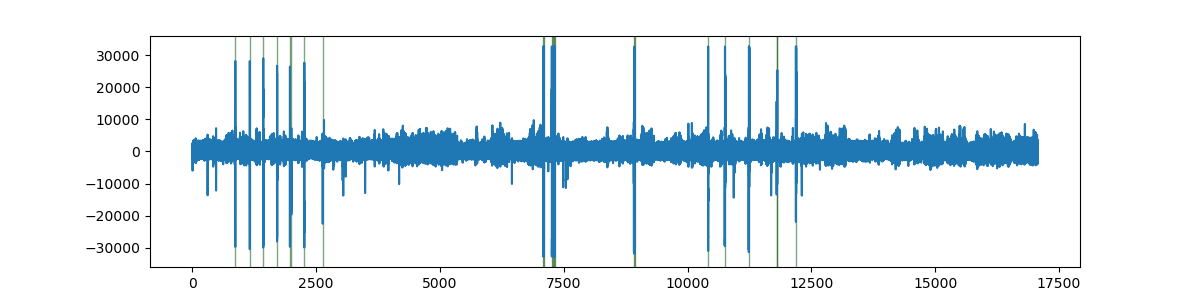

In [14]:
%matplotlib widget

chan_plot = 28
plot_signal_w_epochs(signal, 28, art_epochs)

## Define probe group

/data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/Jyn_training_denoised.probegroup.npy saved


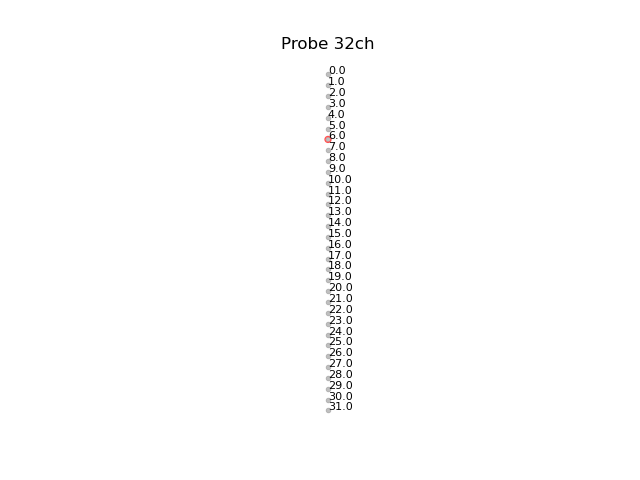

In [15]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=20, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

## Detect Theta epochs

In [16]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 18

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

Best channel for theta: [18]
831 epochs remaining with durations within (1,20)


## Detect SWR Epochs

In [17]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 18
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                     ignore_epochs=art_epochs)


Selected channels for ripples: [18]
9030 epochs remaining with durations within (0.05,0.45)


# Detect Delta

In [18]:
#Detect Delta
from neuropy.analyses.oscillations import detect_hpc_delta_wave_epochs
min_dur = 0.15  
max_dur = 0.5   
ignore_epochs = None  
delta_channel = 18

freq_band = (0.5, 4)

if delta_channel is not None:
    signal_use = signal.time_slice(channel_id=delta_channel)
else:
    signal_use = signal
delta_epochs = detect_hpc_delta_wave_epochs(
    signal_use, freq_band=freq_band, min_dur=min_dur, max_dur=max_dur, ignore_epochs=ignore_epochs
)

1241 delta waves detected


In [19]:
#Detect Beta
from neuropy.analyses.oscillations import detect_beta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
beta_channel = 18
  
if beta_channel is None:
    beta_epochs, beta_power = detect_beta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=beta_channel)
    beta_epochs, beta_power = detect_beta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

Best channel for beta: [18]
617 epochs remaining with durations within (1,20)


In [20]:
# Detect Gamma
from neuropy.analyses.oscillations import detect_gamma_epochs
from neuropy.analyses.oscillations import Gamma
band=(40, 80)
lowthresh = 1.5  
highthresh = 3 
minDistance = 300
minDuration = 125
gamma_channel = 18

# Use this if you don't know the specific channel for gamma detection
if gamma_channel is None:
    signal_use = signal.time_slice(channel_id=gamma_channel)
else:
    # If a specific channel for gamma is known
    signal_use = signal

gammadetect = Gamma()
# gammadetect.get_peak_intervals(signal.traces, lowthresh=lowthresh, highthresh=highthresh, minDistance=minDistance, minDuration=minDuration)
peakevents, gamma_amp = Gamma().get_peak_intervals(signal_use.traces[gamma_channel, :], band=band, lowthresh=lowthresh, highthresh=highthresh, 
                                        minDistance=minDistance, minDuration=minDuration, return_amplitude=True)
# csd=csd(self, period, refchan, band=band, window=1250)
gamma_epochs = Epoch(pd.DataFrame({"start" : peakevents[:, 0]/sess.eegfile.sampling_rate, "stop": peakevents[:, 1]/sess.eegfile.sampling_rate,
                   "label": ""}))
# pd.DataFrame(dict(start=peakevents[:, 0]/sess.eegfile.sampling_rate, stop=peakevents[:, 1]/sess.eegfile.sampling_rate))

In [21]:
gamma_epochs

242 epochs
Snippet: 
       start      stop label
0  422.7984  422.9408      
1  425.8056  425.9536      
2  733.9680  734.3616      
3  800.2200  800.7680      
4  868.7872  869.8960      

## Sync via CS+ or CS- times in tone_recall or control_tone_recall or tone_habituation session

,channel_states,timestamps,datetimes,event_name
913,2,2745124,2022-06-17 11:51:06.504133332,
1062,-2,3042701,2022-06-17 11:51:16.423366667,
1816,2,4564839,2022-06-17 11:52:07.161300000,
1964,-2,4863089,2022-06-17 11:52:17.102966667,
2824,2,6598149,2022-06-17 11:53:14.938300000,


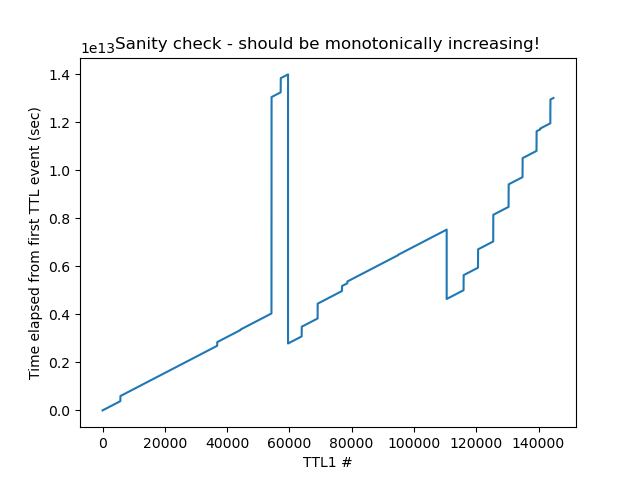

In [22]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

In [23]:
import tracefc.io.traceio as traceio

if "training" in str(sess.basepath):
    # For tone habituation
    csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected')
    print(csn_starts.head(6))
    
    # For CS+ during training
    cs_starts, cs_stops, cs_df = traceio.load_trace_events(sess.basepath, session_type="training", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected')
    print(cs_starts.head(6))
elif "recall" in str(sess.basepath):
    # For tone recall CS+
    cs_starts, cs_stops, cs_df = traceio.load_trace_events(sess.basepath, session_type="tone_recall", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected')
    print(cs_starts.head(6))
    
    # For control tone recall CS-
    csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected')
    print(csn_starts.head(6))

5 CS- events detected
      Time (s)      Event                     Timestamp
5    61.595917  CS1_start 2022-06-17 11:51:06.652631225
7   122.252918  CS2_start 2022-06-17 11:52:07.309632482
9   190.029974  CS3_start 2022-06-17 11:53:15.086687984
11  253.747292  CS4_start 2022-06-17 11:54:18.804005803
13  327.597836  CS5_start 2022-06-17 11:55:32.654550018
6 CS+ events detected
       Time (s)      Event                     Timestamp
6    365.880625  CS1_start 2022-06-17 12:06:08.734140010
16   658.036726  CS2_start 2022-06-17 12:11:00.890240998
26   929.910560  CS3_start 2022-06-17 12:15:32.764074893
36  1208.889620  CS4_start 2022-06-17 12:20:11.743134827
46  1468.570435  CS5_start 2022-06-17 12:24:31.423949570
56  1758.713028  CS6_start 2022-06-17 12:29:21.566542716


In [24]:
sync_df = oeio.create_sync_df(sess.basepath)
sync_df

start time = 2022-06-17 11:49:35.167771-04:00
start time = 2022-06-17 11:59:21.708710-04:00
start time = 2022-06-17 12:36:31.859416-04:00
start time = 2022-06-17 15:27:42.768667-04:00
start time = 2022-06-17 12:36:31.859416-04:00
start time = 2022-06-17 13:00:21.503381-04:00
start time = 2022-06-17 13:41:54.130737-04:00
start time = 2022-06-17 13:54:57.288518-04:00
start time = 2022-06-17 14:01:14.359765-04:00
start time = 2022-06-17 14:04:58.639594-04:00
start time = 2022-06-17 14:26:31.373293-04:00
start time = 2022-06-17 14:35:21.609805-04:00
start time = 2022-06-17 14:35:21.609805-04:00
start time = 2022-06-17 14:35:21.609805-04:00
start time = 2022-06-17 15:19:01.281248-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2022-06-17 11:49:35.167771-04:00,start,0,0.000000,0,0.0000
1,0,2022-06-17 11:56:46.715471-04:00,stop,12946431,431.547700,539434,431.5472
2,1,2022-06-17 11:59:21.708710-04:00,start,12946432,431.547733,539435,431.5480
3,1,2022-06-17 12:35:12.441476667-04:00,stop,77468415,2582.280500,3227850,2582.2800
4,2,2022-06-17 12:36:31.859416-04:00,start,77468416,2582.280533,3227851,2582.2808
5,2,2022-06-17 12:57:25.124449332-04:00,stop,115066367,3835.545567,4794431,3835.5448
6,3,2022-06-17 15:27:42.768667-04:00,start,115066368,3835.545600,4794432,3835.5456
7,3,2022-06-17 15:43:29.303033667-04:00,stop,143462399,4782.079967,5977599,4782.0792
8,4,2022-06-17 12:36:31.859416-04:00,start,143462400,4782.080000,5977600,4782.0800
9,4,2022-06-17 13:57:48.548449333-04:00,stop,289763071,9658.769033,12073461,9658.7688


In [25]:
# Grab CS times corresponding to OE timestamps
ttl_lag_use = pd.Timedelta(0.8, unit="seconds")
cs_oe_start_df = traceio.trace_ttl_to_openephys(cs_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
cs_oe_stop_df = traceio.trace_ttl_to_openephys(cs_stops, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
# Convert to times in combined eeg file
cs_starts_combined = oeio.recording_events_to_combined_time(cs_oe_start_df, sync_df)
cs_stops_combined = oeio.recording_events_to_combined_time(cs_oe_stop_df, sync_df)

csn_oe_start_df = traceio.trace_ttl_to_openephys(csn_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)
csn_oe_stop_df = traceio.trace_ttl_to_openephys(csn_stops, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)

# Convert to times in combined eeg file
csn_starts_combined = oeio.recording_events_to_combined_time(csn_oe_start_df, sync_df)
csn_stops_combined = oeio.recording_events_to_combined_time(csn_oe_stop_df, sync_df)

start time lag: mean = -0.7076860578333334, std = 0.0010682421575040585
start time lag: mean = -0.7078422188333332, std = 0.0010084827325533058
start time lag: mean = -0.14844150279999999, std = 7.832780814436662e-05
start time lag: mean = -0.14862750600000002, std = 0.0001458178142014915


/data/GitHub/TraceFC/tracefc/io/traceio.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace_cs_sync_df.loc[:, "datetimes"] = trace_cs_sync_df["datetimes"].dt.tz_localize(


### How to write CS+ to neuroscope event file

In [26]:
cs_tone_recall_epochs = Epoch({"start": cs_starts_combined, "stop": cs_stops_combined, "label": ["CS+"]*len(cs_starts_combined)})
cs_tone_recall_epochs
sess.recinfo.write_epochs(cs_tone_recall_epochs, "cs+")

In [27]:
csp_wav = sorted((sess.basepath / "2_training").glob("**/*.WAV"))[0]

/data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/2_training/shockbox/T0000001.WAV
Mean start lag time of 364.333 sec with std = 0.059 sec. Add lags from wavfile times to get ephys times
Mean stop lag time of 363.879 sec with std = 0.092 sec.


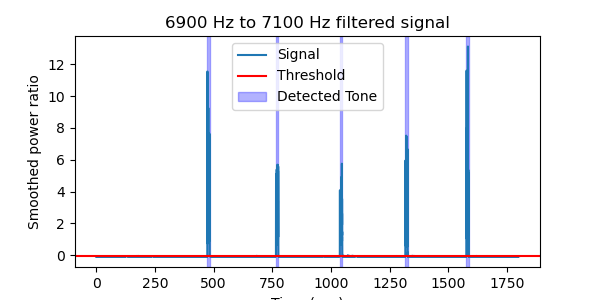

In [28]:
from tracefc.io.traceio import grab_usv_folder
csp_wav = grab_usv_folder(sess.basepath, 'csp')
print(csp_wav)
# Get CS+ times and plot to check
cs_wav_epochs = detect_tone(csp_wav, freq_lims=(6900, 7100), thresh=-0.07, tone_length=8, tone_label="CS+", plot_check=True)
# Check that lags are consistent
if (animal == 'Jyn') & (sess_name == 'training'):
    cs_starts_combined = cs_starts_combined[:5]
    cs_stops_combined = cs_stops_combined[:5]
cs_start_lags = cs_starts_combined - cs_wav_epochs.starts
print(f"Mean start lag time of {np.mean(cs_start_lags):0.3F} sec with std = {np.std(cs_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
cs_stop_lags = cs_stops_combined - cs_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(cs_stop_lags):0.3F} sec with std = {np.std(cs_stop_lags):0.3F} sec.")

Ditto for CS-

/data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/1_tone_habituation/restbox/T0000001.WAV
Mean start lag time of 13.183 sec with std = 0.020 sec. Add lags from wavfile times to get ephys times
Mean stop lag time of 12.939 sec with std = 0.057 sec.


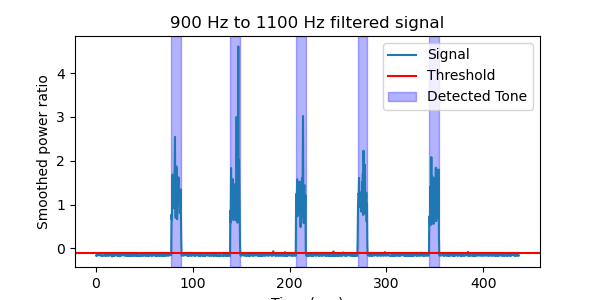

In [29]:
# Detect CS- in audio recording.
if "recall" in str(sess.basepath):
    csn_wav = sorted((sess.basepath / "2_control_tone_recall").glob("**/*.WAV"))[0]
elif "training" in str(sess.basepath):
    csn_wav = sorted((sess.basepath / "1_tone_habituation").glob("**/*.WAV"))[0]
print(csn_wav)

# Get CS+ times and plot to check
csn_wav_epochs = detect_tone(csn_wav, freq_lims=(900, 1100), thresh=-0.1, tone_length=10, tone_label="CS-", plot_check=True)

# Check that lags are consistent
csn_start_lags = csn_starts_combined - csn_wav_epochs.starts
print(f"Mean start lag time of {np.mean(csn_start_lags):0.3F} sec with std = {np.std(csn_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
csn_stop_lags = csn_stops_combined - csn_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(csn_stop_lags):0.3F} sec with std = {np.std(csn_stop_lags):0.3F} sec.")

Now try to sync to start tone 

/data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/3_post/restbox/T0000002.WAV
No tones detected at thresh=10 and length=0.5. Adjust power/time thresholds and re-run


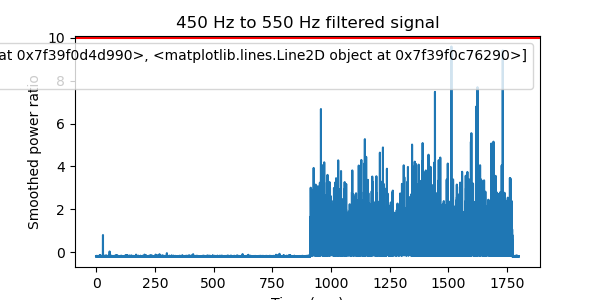

In [30]:
if "recall" in str(sess.basepath):
    no_tone_wav = sorted((sess.basepath / "3_ctx_recall").glob("**/*.WAV"))[0]
elif "training" in str(sess.basepath):
    no_tone_wav = sorted((sess.basepath / "3_post").glob("**/*.WAV"))[0]
print(no_tone_wav)

# Get CS+ times and plot to check
start_wav_epochs = detect_tone(no_tone_wav, freq_lims=(450, 550), thresh=10, tone_length=0.5, tone_label="start_tone", plot_check=True)

## Sync recorded USV times to ephys file

In [31]:
# Read in USV times from tone recall session
from neuropy.io.usvio import DeepSqueakIO
csp_wav = Path(csp_wav)
usv_detect_file = sorted(csp_wav.parent.glob(f"**/{csp_wav.name[:-4]}*_cell.mat"))[0]

ds_calls = DeepSqueakIO(filename=usv_detect_file)
ds_calls.load_calls()
ds_calls.usv_df

,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept
0,505.926529,47.944444,0.045134,27.777778,1.000000,1
1,506.961084,45.345779,0.073317,25.343152,1.000000,1
2,507.356846,50.209416,0.040911,5.905844,1.000000,1
3,507.761818,46.842283,0.095608,5.095238,1.000000,1
4,508.206287,45.924784,0.070048,5.326840,1.000000,1
5,508.423960,42.557651,0.073417,27.213203,1.000000,1
6,509.104458,38.860931,0.046408,29.645022,1.000000,1
7,509.381408,42.366841,0.096464,7.597611,0.544231,1
8,509.652919,37.355519,0.035965,29.521707,1.000000,1
9,509.889394,43.608766,0.150152,8.221861,0.544231,1


Plot lags vs time to check for drift between ephys and audio recordings and correct if necessary

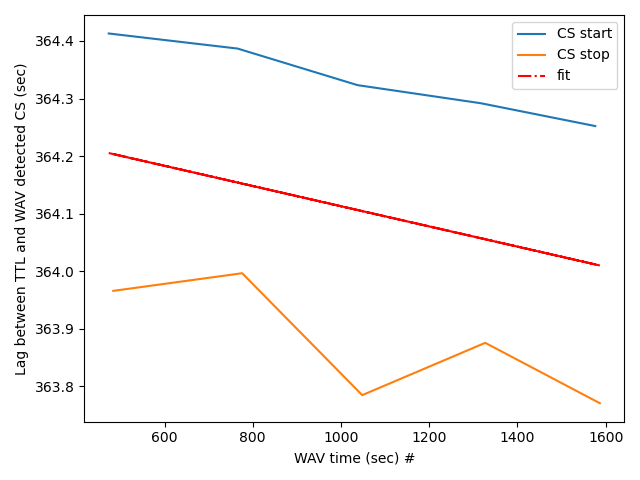

In [32]:
from scipy.linalg import lstsq

_, ax = plt.subplots(layout='tight')
cs_times_wav = np.stack((cs_wav_epochs.starts, cs_wav_epochs.stops), axis=1)
cs_lags_comb = np.stack((cs_start_lags, cs_stop_lags), axis=1)
hl = ax.plot(cs_times_wav, cs_lags_comb)
ax.set_xlabel('WAV time (sec) #')
ax.set_ylabel('Lag between TTL and WAV detected CS (sec)')
ax.legend(hl, ('CS Start', 'CS Stop'))

# Fit function to approximate drift
y = cs_lags_comb.T.reshape(-1)
M = np.stack((np.ones_like(cs_lags_comb.reshape(-1)), cs_times_wav.T.reshape(-1)), axis=1)
p, res, rnk, s = lstsq(M, y)
hfit = ax.plot(cs_times_wav.T.reshape(-1), p[0] + p[1]*cs_times_wav.T.reshape(-1), 'r-.')
hl.extend(hfit)
ax.legend(hl, ('CS start', 'CS stop', 'fit'))

In [33]:
# Sanity check code to output corrected CS times from WAV file to Neuroscope
cs_wav_starts_aligned = cs_wav_epochs.starts + p[0] + p[1]*cs_wav_epochs.starts
cs_wav_stops_aligned = cs_wav_epochs.stops + p[0] + p[1]*cs_wav_epochs.stops
cs_wav_epochs_aligned = Epoch({"start": cs_wav_starts_aligned, "stop": cs_wav_stops_aligned, 
                               "label": ["CS+ from WAV file"]*len(cs_wav_stops_aligned)})


cs_epochs_files = sess.filePrefix.with_suffix(".cs_wav_epochs.npy")
cs_wav_epochs_aligned.save(cs_epochs_files)
sess.recinfo.write_epochs(cs_wav_epochs_aligned, ext="wv+")

/data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/Jyn_training_denoised.cs_wav_epochs.npy saved


In [34]:
cs_wav_epochs_aligned

5 epochs
Snippet: 
          start         stop              label
0   837.659482   848.026707  CS+ from WAV file
1  1129.790012  1140.113032  CS+ from WAV file
2  1401.679094  1412.155402  CS+ from WAV file
3  1680.639969  1690.973942  CS+ from WAV file
4  1940.314397  1950.731726  CS+ from WAV file

Now correct that drift and find corrected lags!

In [35]:
# This should eventually be folded into the DeepSqueakIO class!
# Bowen question: 
calls_accept_df = ds_calls.usv_df[ds_calls.usv_df['Accept'] == 1]
call_starts_wav = calls_accept_df['Begin_Time'].values
call_stops_wav = call_starts_wav + calls_accept_df['Duration'].values
calls_accept_df.insert(0, "start", call_starts_wav + p[0] + p[1]*call_starts_wav)
calls_accept_df.insert(1, "stop", call_stops_wav + p[0] + p[1]*call_stops_wav)
calls_accept_df.insert(calls_accept_df.shape[1], "label", "")
good_calls = Epoch(calls_accept_df)

# output to neuroscope and neuropy
sess.recinfo.write_epochs(good_calls, ext="usv")
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
good_calls.save(usv_epochs_file)

/data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/Jyn_training_denoised.usv_epochs.npy saved


In [36]:
good_calls

16 epochs
Snippet: 
         start        stop  Begin_Time   Freq_Min  Duration  Freq_Range  Score  \
0  870.126212  870.171338  505.926529  47.944444  0.045134   27.777778    1.0   
1  871.160586  871.233890  506.961084  45.345779  0.073317   25.343152    1.0   
2  871.556279  871.597182  507.356846  50.209416  0.040911    5.905844    1.0   
3  871.961179  872.056770  507.761818  46.842283  0.095608    5.095238    1.0   
4  872.405570  872.475605  508.206287  45.924784  0.070048    5.326840    1.0   

   Accept label  
0       1        
1       1        
2       1        
3       1        
4       1        

## Save notebook to working directory

In [37]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [38]:
import neuropy.io.openephysio as oeio
sync_df = oeio.create_sync_df(sess.basepath)
sync_df["Time since rec start (sec)"] = (sync_df['Datetime'] - sync_df.loc[0, 'Datetime']).dt.total_seconds()
sync_df

start time = 2022-06-17 11:49:35.167771-04:00
start time = 2022-06-17 11:59:21.708710-04:00
start time = 2022-06-17 12:36:31.859416-04:00
start time = 2022-06-17 15:27:42.768667-04:00
start time = 2022-06-17 12:36:31.859416-04:00
start time = 2022-06-17 13:00:21.503381-04:00
start time = 2022-06-17 13:41:54.130737-04:00
start time = 2022-06-17 13:54:57.288518-04:00
start time = 2022-06-17 14:01:14.359765-04:00
start time = 2022-06-17 14:04:58.639594-04:00
start time = 2022-06-17 14:26:31.373293-04:00
start time = 2022-06-17 14:35:21.609805-04:00
start time = 2022-06-17 14:35:21.609805-04:00
start time = 2022-06-17 14:35:21.609805-04:00
start time = 2022-06-17 15:19:01.281248-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time,Time since rec start (sec)
0,0,2022-06-17 11:49:35.167771-04:00,start,0,0.000000,0,0.0000,0.000000
1,0,2022-06-17 11:56:46.715471-04:00,stop,12946431,431.547700,539434,431.5472,431.547700
2,1,2022-06-17 11:59:21.708710-04:00,start,12946432,431.547733,539435,431.5480,586.540939
3,1,2022-06-17 12:35:12.441476667-04:00,stop,77468415,2582.280500,3227850,2582.2800,2737.273706
4,2,2022-06-17 12:36:31.859416-04:00,start,77468416,2582.280533,3227851,2582.2808,2816.691645
5,2,2022-06-17 12:57:25.124449332-04:00,stop,115066367,3835.545567,4794431,3835.5448,4069.956678
6,3,2022-06-17 15:27:42.768667-04:00,start,115066368,3835.545600,4794432,3835.5456,13087.600896
7,3,2022-06-17 15:43:29.303033667-04:00,stop,143462399,4782.079967,5977599,4782.0792,14034.135263
8,4,2022-06-17 12:36:31.859416-04:00,start,143462400,4782.080000,5977600,4782.0800,2816.691645
9,4,2022-06-17 13:57:48.548449333-04:00,stop,289763071,9658.769033,12073461,9658.7688,7693.380678


In [39]:
import neuropy.io.miniscopeio as miniio
mini = miniio.MiniscopeIO(sess.basepath)

In [40]:
mini.load_all_orientation()
mini.load_all_timestamps()

including folder /data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/1_tone_habituation/tone_habituation/Jyn/gobears/2022_06_17/11_50_05
including folder /data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/2_training/training/Jyn/gobears/2022_06_17/12_00_02
including folder /data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/3_post/post/Jyn/gobears/2022_06_17/12_37_30
including folder /data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/3_post/post/Jyn/gobears/2022_06_17/12_46_16
including folder /data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/3_post/post/Jyn/gobears/2022_06_17/13_07_28
including folder /data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/3_post/post/Jyn/gobears/2022_06_17/13_24_00
including folder /data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/3_post/post/Jyn/gobears/2022_06_17/13_41_55
including folder /data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/3_post/post/Jyn/gobears/2022_06_17/14_05_56
including folder /data2/Trace_FC/Recordi

,Frame Number,Time Stamp (ms),Buffer Index,Timestamps
0,0,-65,0,2022-06-17 11:50:05.018
1,1,28,0,2022-06-17 11:50:05.111
2,2,69,0,2022-06-17 11:50:05.152
3,3,137,0,2022-06-17 11:50:05.220
4,4,204,0,2022-06-17 11:50:05.287
...,...,...,...,...
15587,15587,1050158,0,2022-06-17 17:06:09.941
15588,15588,1050225,0,2022-06-17 17:06:10.008
15589,15589,1050292,0,2022-06-17 17:06:10.075
15590,15590,1050359,0,2022-06-17 17:06:10.142


In [41]:
rough_headsensor_times = (mini.orient_all["Timestamps"].dt.tz_localize(tz="America/Detroit") - sync_df.loc[0, "Datetime"]).dt.total_seconds()
mini.orient_all["Rough eeg time (s)"] = rough_headsensor_times
mini.orient_all

,Time Stamp (ms),qw,qx,qy,qz,Timestamps,roll,pitch,yaw,Rough eeg time (s)
0,-65,-0.812195,-0.578674,-0.042297,0.060852,2022-06-17 11:50:05.018,1.234599,0.139587,-0.050403,29.850229
1,28,-0.810730,-0.583496,-0.035400,0.031616,2022-06-17 11:50:05.111,1.247204,0.094436,-0.009997,29.943229
2,69,-0.804993,-0.591553,-0.033691,0.031006,2022-06-17 11:50:05.152,1.267058,0.091052,-0.010096,29.984229
3,137,-0.804382,-0.592224,-0.000671,0.047607,2022-06-17 11:50:05.220,1.267121,0.057500,-0.075990,30.052229
4,204,-0.798706,-0.594604,0.050049,0.077393,2022-06-17 11:50:05.287,1.278755,0.012088,-0.184202,30.119229
...,...,...,...,...,...,...,...,...,...,...
15587,1050158,-0.833252,-0.345398,-0.290527,0.319397,2022-06-17 17:06:09.941,0.582093,0.782134,-0.486322,18994.773229
15588,1050225,-0.833252,-0.345398,-0.290466,0.319458,2022-06-17 17:06:10.008,0.582042,0.782049,-0.486503,18994.840229
15589,1050292,-0.833191,-0.345398,-0.290527,0.319519,2022-06-17 17:06:10.075,0.581960,0.782212,-0.486649,18994.907229
15590,1050359,-0.833313,-0.344849,-0.290649,0.319641,2022-06-17 17:06:10.142,0.580329,0.782232,-0.487511,18994.974229


In [42]:
rough_headsensor_times = (mini.orient_all["Timestamps"].dt.tz_localize(tz="America/Detroit") - sync_df.loc[0, "Datetime"]).dt.total_seconds()
mini.orient_all["Time from OE start"] = rough_headsensor_times
mini.orient_all

# Key line of code - converts miniscope time (which doesn't account for disconnects) to eeg time (which cuts out disconnect times)
mini.orient_all["Rough eeg time (s)"] = np.interp(mini.orient_all["Time from OE start"], sync_df["Time since rec start (sec)"], 
                                            sync_df["eeg_time"])
mini.orient_all

,Time Stamp (ms),qw,qx,qy,qz,Timestamps,roll,pitch,yaw,Rough eeg time (s),Time from OE start
0,-65,-0.812195,-0.578674,-0.042297,0.060852,2022-06-17 11:50:05.018,1.234599,0.139587,-0.050403,29.850194,29.850229
1,28,-0.810730,-0.583496,-0.035400,0.031616,2022-06-17 11:50:05.111,1.247204,0.094436,-0.009997,29.943194,29.943229
2,69,-0.804993,-0.591553,-0.033691,0.031006,2022-06-17 11:50:05.152,1.267058,0.091052,-0.010096,29.984194,29.984229
3,137,-0.804382,-0.592224,-0.000671,0.047607,2022-06-17 11:50:05.220,1.267121,0.057500,-0.075990,30.052194,30.052229
4,204,-0.798706,-0.594604,0.050049,0.077393,2022-06-17 11:50:05.287,1.278755,0.012088,-0.184202,30.119194,30.119229
...,...,...,...,...,...,...,...,...,...,...,...
15587,1050158,-0.833252,-0.345398,-0.290527,0.319397,2022-06-17 17:06:09.941,0.582093,0.782134,-0.486322,17071.188800,18994.773229
15588,1050225,-0.833252,-0.345398,-0.290466,0.319458,2022-06-17 17:06:10.008,0.582042,0.782049,-0.486503,17071.188800,18994.840229
15589,1050292,-0.833191,-0.345398,-0.290527,0.319519,2022-06-17 17:06:10.075,0.581960,0.782212,-0.486649,17071.188800,18994.907229
15590,1050359,-0.833313,-0.344849,-0.290649,0.319641,2022-06-17 17:06:10.142,0.580329,0.782232,-0.487511,17071.188800,18994.974229


In [43]:
cs_epochs_file = sess.filePrefix.with_suffix(".cs_epochs.npy")
sess.cs_epochs = Epoch(epochs=None, file=cs_epochs_file)
sess.cs_epochs.starts

FileNotFoundError: [Errno 2] No such file or directory: '/data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/Jyn_training_denoised.cs_epochs.npy'